In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display
from PIL import Image

# Load images from folder and to a list 

In [2]:
import glob
filelist = glob.glob('./images/*.PNG')

In [3]:
x = np.array([np.array(Image.open(fname)).tolist() for fname in filelist])

In [4]:
train_images = x.reshape(x.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE =4000
BATCH_SIZE = 512
#batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

# Generator Model

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*36, use_bias=False, input_shape=(5,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 36)))
    assert model.output_shape == (None, 8, 8, 36) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(36, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 36)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(18, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 18)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(9, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 9)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    """
    model.add(layers.Conv2DTranspose(9, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 9)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    """
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [7]:
make_generator_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2304)              11520     
_________________________________________________________________
batch_normalization (BatchNo (None, 2304)              9216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2304)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 36)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 36)          32400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 36)          144       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 36)          0

In [8]:
#noise = tf.random.normal([1, 100])
z = np.random.uniform(-1., 1., size=[1, 5])
#noise
z

array([[ 0.89743459, -0.28203362,  0.21705719,  0.21763823, -0.30091324]])

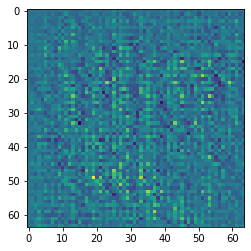

In [9]:
generator = make_generator_model()
generated_image = generator(z, training=False)

plt.imshow(generated_image[0, :, :, 0])

# Discriminatior Model

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00022248]], shape=(1, 1), dtype=float32)


## Loss Function

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS = 10000
noise_dim = 5
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = np.random.uniform(-1., 1., size=[BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for a in zip(dataset):
            train_step(a)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 200 epochs
        if (epoch + 1) % 200 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    #Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    plt.imshow(predictions[0])
    #for i in range(predictions.shape[0]):
    #    plt.subplot(4, 4, i+1)
     #   plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
    #    plt.axis('off')
    pa="./gen1/"
    na=epoch
    ex=".png"
    plt.savefig(pa+str(epoch)+ex)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


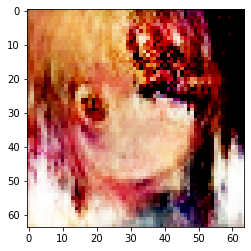

Time for epoch 1014 is 4.816129922866821 sec


KeyboardInterrupt: 

In [23]:
train(train_dataset, EPOCHS)

# Prediction with random seed

In [ ]:
z1=np.random.uniform(-1., 1., size=[1, 100])

In [ ]:
predictions = generator(z1, training=False)
fig = plt.figure(figsize=(4,4))
plt.imshow(predictions[0])


# Restore checkpoint

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))